In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# NumPy is only used to load the .npz partially processed data file. It is later converted to pandas datasets
from numpy import load
import numpy

# load the dataset from its location in the Google Drive
data = load('/content/drive/MyDrive/Colab Notebooks/FacebookNetworkGCN/PatternFlow/recognition/FacebookNetworkGCN/facebook.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

edges
[[    0 18427]
 [18427     0]
 [    1 21708]
 ...
 [ 5563  5563]
 [22425 22425]
 [22425 22425]]
features
[[-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.36413375
  -0.12863389]
 [-0.26257643 -0.26505256 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 ...
 [-0.26257643 -0.27648264 -0.26235026 ... -0.18038896 -0.37209702
  -0.22261272]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.21814811]
 [-0.23227507 -0.27648264 -0.26235026 ... -0.19585785 -0.3759032
  -0.2212746 ]]
target
[0 2 1 ... 2 1 0]


In [3]:
# Load the necessary libraries. TensorFlow is the primary library used

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Initialise the data

In [50]:
# Load the edges as a pandas dataframe
edges = data["edges"]
edges = pd.DataFrame(data=edges, columns=["source", "target"])

print("Edges shape:", edges.shape)

Edges shape: (342004, 2)


In [5]:
edges.sample(frac=1).head()

,source,target
160217,8188,6094
40793,21569,11401
228382,9525,18966
319672,16770,20513
224881,13252,9319


In [51]:
# Load the pages as a pandas dataframe
id = numpy.arange(22470)
id = pd.DataFrame(data=id)

categories = data["target"]
categories = pd.DataFrame(data=categories)

pages = data["features"]
pages = pd.DataFrame(data=pages)

pages = numpy.concatenate((id, pages, categories), axis=1)

row_names = ["id"] + [f"term_{idx}" for idx in range(128)] + ["category"]
pages = pd.DataFrame(data=pages, columns=row_names)

N = pages.shape[0] #the number of nodes
F = pages.shape[1] #the number of features

print("Pages shape:", pages.shape)
print('Number of nodes (N): ', N)
print('Number of features (F) of each node: ', F)

Pages shape: (22470, 130)
Number of nodes (N):  22470
Number of features (F) of each node:  130


In [7]:
print(pages.sample(5).T)

                 17398        4196         4056          12103         21340
id        17398.000000  4196.000000  4056.000000  12103.000000  21340.000000
term_0       -0.251192    -0.262576    -0.262576     -0.262576     -0.262576
term_1       -0.276483    -0.276483    -0.276483      6.776217      3.174779
term_2       -0.262350    -0.262350    -0.262350     -0.254570     -0.262350
term_3       -0.299327     3.540913    -0.295363     -0.299327     -0.299327
...                ...          ...          ...           ...           ...
term_124     -0.255755    -0.255755    -0.251167     -0.255755     -0.255755
term_125     -0.215140    -0.215140    -0.197858     -0.215140     -0.215140
term_126     -0.375903    -0.375903    -0.375903     -0.375903     -0.375903
term_127     -0.223836    -0.223836    -0.170604     -0.223836     -0.223836
category      2.000000     0.000000     2.000000      1.000000      1.000000

[130 rows x 5 columns]


In [8]:
# Display a count of the number of pages in each category, 
# where the category is represented by a number from 0 to 3.
print(pages.category.value_counts())

2.0    6880
1.0    6495
3.0    5768
0.0    3327
Name: category, dtype: int64


In [52]:
# Convert the page id and edge into zero-based indices 

class_values = sorted(pages["category"].unique())

class_idx = {name: idx for idx, name in enumerate(class_values)}
pages["category"] = pages["category"].apply(lambda value: class_idx[value])

page_idx = {name: idy for idy, name in enumerate(sorted(pages["id"].unique()))}
pages["id"] = pages["id"].apply(lambda name: page_idx[name])
edges["source"] = edges["source"].apply(lambda name: page_idx[name])
edges["target"] = edges["target"].apply(lambda name: page_idx[name])

Visualise the graph

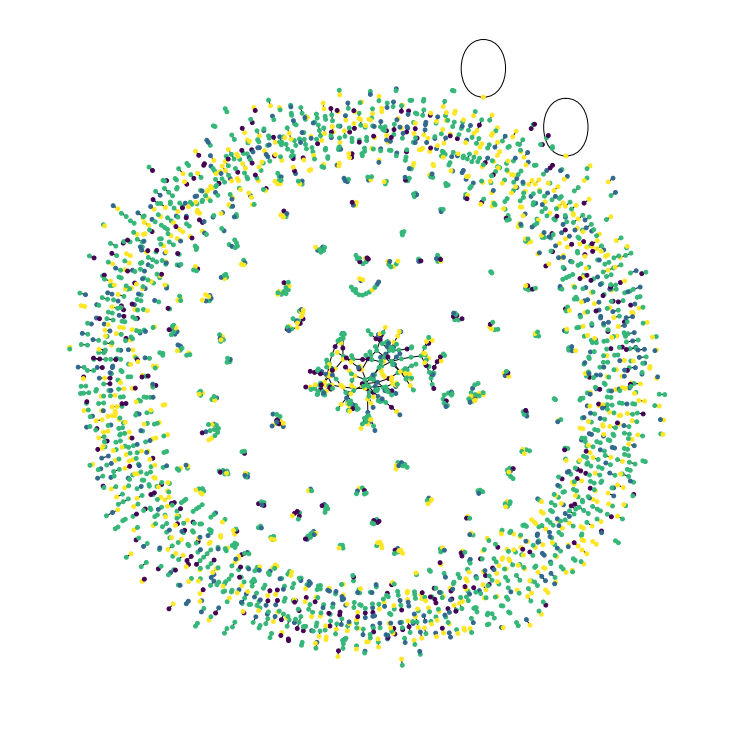

In [10]:
plt.figure(figsize=(10, 10))

colours = pages["category"].tolist()

fb_graph = nx.from_pandas_edgelist(edges.sample(n=2000))
page_type = list(pages[pages["id"].isin(list(fb_graph.nodes))]["category"])
nx.draw_spring(fb_graph, node_size=15, node_color=page_type)

In [53]:
# We split the data into train, validation, and test data sets, using a 20:20:60
# train:validation:test split for semi supervised

train_data, val_data, test_data = [], [], []

for _, grouped_data in pages.groupby("category"):
    dataset_length = len(grouped_data.index)
    train_data.append(grouped_data[:dataset_length//10*2])
    val_data.append(grouped_data[dataset_length//10*2:dataset_length//10*4])
    test_data.append(grouped_data[dataset_length//10*4:])

train_data = pd.concat(train_data).sample(frac=1)
val_data = pd.concat(val_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4490, 130)
Validation data shape: (4490, 130)
Test data shape: (13490, 130)


In [54]:
# Prepare the data for training the model

feature_names = set(pages.columns) - {"id", "category"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Convert test, validate, and train pandas datasets features to tensors.
x_train = tf.convert_to_tensor(train_data[feature_names])
x_validate = tf.convert_to_tensor(val_data[feature_names])
x_test = tf.convert_to_tensor(test_data[feature_names])

# Obtain test, validate, and train pandas datasets targets.
y_train = train_data["category"]
y_validate = val_data["category"]
y_test = test_data["category"]

In [55]:
train_mask = numpy.zeros((N,),dtype=bool)
ls_train = [int(x) for x in train_data["id"].tolist()]
train_mask[ls_train] = True

val_mask = numpy.zeros((N,),dtype=bool)
ls_val = [int(x) for x in val_data["id"].tolist()]
val_mask[ls_val] = True

test_mask = numpy.zeros((N,),dtype=bool)
ls_test = [int(x) for x in test_data["id"].tolist()]
test_mask[ls_test] = True

In [14]:
labels_encoded = []
for value in pages.category:
  letter = [0 for _ in range(len(set(pages.category)))]
  letter[value] = 1
  labels_encoded.append(letter)
print(labels_encoded)

[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0

In [33]:
# Parameters
channels = 16                 #
stopping_patience = 50        # Patience for early stopping
hidden_units = [128, 128]     #
learning_rate = 0.001         # Learning rate
dropout_rate = 0.5           # Dropout rate for the features
l2_reg = 5*10**(-4)           #
num_epochs = 300              # Number of training epochs
batch_size = 512              #

In [17]:
!pip install spektral

     |████████████████████████████████| 123 kB 37.8 MB/s 


In [57]:
from spektral.layers import GATConv

# Model definition
X_in = layers.Input(shape=(F, ))
fltr_in = layers.Input((N, ), sparse=True)

dropout_1 = layers.Dropout(dropout_rate)(X_in)
graph_conv_1 = GATConv(channels,
                         activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = layers.Dropout(dropout_rate)(graph_conv_1)
graph_conv_2 = GATConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = tf.keras.Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 130)]        0                                            
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 130)          0           input_27[0][0]                   
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 22470)]      0                                            
__________________________________________________________________________________________________
gat_conv_4 (GATConv)            (None, 16)           2112        dropout_21[0][0]                 
                                                                 input_28[0][0]             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [58]:

#A = numpy.array(A)

X = data["features"]
X = pd.DataFrame(data=pages)
X = numpy.array(X)

#build the graph
G = nx.Graph()
pages = pages["id"]
pages = numpy.array(pages)
edges = data["edges"]
edges = numpy.array(edges)
G.add_nodes_from(pages)
G.add_edges_from(edges)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

A = GATConv.preprocess(A).astype('f4')

# Train model

early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=stopping_patience, restore_best_weights=True
    )

train_mask = numpy.array(train_mask)
val_mask = numpy.array(val_mask)
test_mask = numpy.array(test_mask)

labels_encoded = numpy.array(labels_encoded)

validation_data = ([X, A], labels_encoded, val_mask)

model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=num_epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[early_stopping]
          )


Graph info:  Graph with 22470 nodes and 171002 edges
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_7/gat_conv_5/Reshape_5:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_7/gat_conv_5/Reshape_4:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_7/gat_conv_5/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_7/gat_conv_5/Reshape_8:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_7/gat_conv_5/Reshape_7:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_7/gat_conv_5/Cast_2:0", shape=(2,), dtype=int32))) to a

1/1 [==============================] - 8s 8s/step - loss: 1.6495 - acc: 0.1797 - val_loss: 9.1560 - val_acc: 0.1481
Epoch 2/300
1/1 [==============================] - 1s 1s/step - loss: 1.2270 - acc: 0.1913 - val_loss: 8.6157 - val_acc: 0.1481
Epoch 3/300
1/1 [==============================] - 1s 1s/step - loss: 1.3499 - acc: 0.2038 - val_loss: 8.0781 - val_acc: 0.1481
Epoch 4/300
1/1 [==============================] - 1s 1s/step - loss: 1.1889 - acc: 0.2122 - val_loss: 7.5162 - val_acc: 0.1481
Epoch 5/300
1/1 [==============================] - 1s 1s/step - loss: 0.9538 - acc: 0.2263 - val_loss: 6.9156 - val_acc: 0.1481
Epoch 6/300
1/1 [==============================] - 1s 1s/step - loss: 1.0451 - acc: 0.2405 - val_loss: 6.2887 - val_acc: 0.1481
Epoch 7/300
1/1 [==============================] - 1s 1s/step - loss: 0.7717 - acc: 0.2383 - val_loss: 5.3692 - val_acc: 0.1481
Epoch 8/300
1/1 [==============================] - 1s 1s/step - loss: 0.8287 - acc: 0.2686 - val_loss: 2.3760 - val_

In [36]:

# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

ValueError: ignored

In [ ]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConv, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [ ]:
# This function implents a feedforward network to be used in the GCN
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation='relu'))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
# The train_model function compiles and trains the model using the x_train and y_train data
def train_model(model, x_train, y_train):
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    # Create an early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=stopping_patience, restore_best_weights=True
    )

    # Fit the model
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
# This function implements a baseline classifier
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create a FFN block
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

# Creates the baseline model
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 128)          103168      input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 128)          103168      ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 128)          0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [ ]:
# Trains the baseline model
history = train_model(baseline_model, x_train, y_train)

Epoch 1/300
19/19 [==============================] - 17s 200ms/step - loss: 2.6976 - acc: 0.2900 - val_loss: 1.3637 - val_acc: 0.3215
Epoch 2/300
19/19 [==============================] - 2s 130ms/step - loss: 2.0426 - acc: 0.3291 - val_loss: 1.3806 - val_acc: 0.3185
Epoch 3/300
19/19 [==============================] - 3s 138ms/step - loss: 1.7866 - acc: 0.3526 - val_loss: 1.3553 - val_acc: 0.3399
Epoch 4/300
19/19 [==============================] - 3s 134ms/step - loss: 1.6179 - acc: 0.3731 - val_loss: 1.3293 - val_acc: 0.3826
Epoch 5/300
19/19 [==============================] - 3s 135ms/step - loss: 1.4985 - acc: 0.3981 - val_loss: 1.3161 - val_acc: 0.3796
Epoch 6/300
19/19 [==============================] - 3s 134ms/step - loss: 1.4093 - acc: 0.4282 - val_loss: 1.2765 - val_acc: 0.3956
Epoch 7/300
19/19 [==============================] - 2s 132ms/step - loss: 1.3387 - acc: 0.4402 - val_loss: 1.2356 - val_acc: 0.4448
Epoch 8/300
19/19 [==============================] - 2s 132ms/step -

In [ ]:
# Evaluate the baseline models accuracy
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.59%
